In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from collections import OrderedDict
%matplotlib inline

In [2]:
# n1, n2, n3 indicate which cell nucleus the features correspond to

cols = [i+j for i in ['n1_','n2_','n3_'] for j in ['radius', 'texture', 
                                            'perimeter', 'area',
                                            'smoothness','compactness',
                                            'concavity',
                                            'concave_points','symmetry',
                                            'fractal_dim']]
cols = ['id','diagnosis']+cols

In [3]:
df = pd.read_csv('breast_cancer_data.csv', header=None, names=cols)
df.drop(['id'], axis=1, inplace=True)

In [4]:
#setting up the training data and shuffling
df = df.sample(frac=1)
X, y = df.iloc[:, 1:len(df.columns)], df['diagnosis']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y,
                                               test_size=0.75)

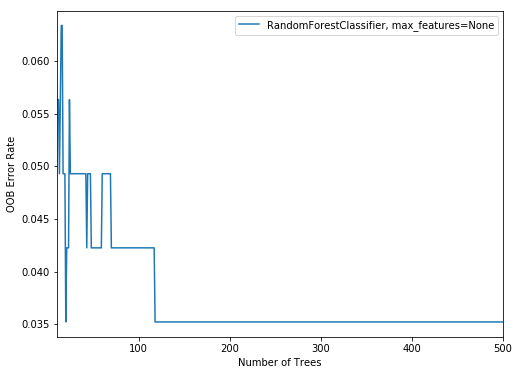

In [5]:
#setting up parameters for testing a range of classifiers to evaluate best #
rf_clfs_list = [ ("RandomForestClassifier, max_features=None", 
                  RandomForestClassifier(warm_start=True, 
                                         max_features=None, 
                                         oob_score=True))]
min_trees = 10
max_trees = 500
error_rate = OrderedDict((label, []) for label, _ in rf_clfs_list)

figure(figsize=(8,6))
# using sklearn recipe for nice visualization of oob error
for label, rf_clf in rf_clfs_list:
    for i in range(min_trees, max_trees+1):
        rf_clf.set_params(n_estimators=i)
        rf_clf.fit(Xtrain, ytrain)
        oob_error = 1 - rf_clf.oob_score_
        error_rate[label].append((i, oob_error))
        
for label, rf_clf_error in error_rate.items():
    xs, ys = zip(*rf_clf_error)
    plt.plot(xs, ys, label=label)

plt.xlim(min_trees, max_trees)
plt.xlabel("Number of Trees")
plt.ylabel("OOB Error Rate")
plt.legend(loc='upper right')
plt.show()

In [6]:
rf_clf = RandomForestClassifier(n_estimators=150,
                                warm_start=True, 
                                max_features=None,
                                oob_score=True)

In [7]:
rf_clf.fit(Xtrain, ytrain)
ypred = rf_clf.predict(Xtest)

In [8]:
def binaryPerfReport(ytest, ypredict, output='metrics', 
                     labs=[True, False], cols=['T Pred', 'F Pred'],
                     idx=['T Act', 'F Act']): 
    cm = pd.DataFrame(data=confusion_matrix(ytest, ypredict, 
                      labels=labs),
                      columns=cols,
                      index=idx)
    
    cols = ['Sensitivity', 'Specificity', 'F1', 'Accuracy']
    dfperf = pd.DataFrame(index=idx, 
                          columns=cols)
    for j in range(0, len(cm)):
        if j == 0:
            tp, fn, fp, tn = confusion_matrix(ytest, ypredict).ravel()
        elif j == 1:
            tn, fp, fn, tp = confusion_matrix(ytest, ypredict).ravel()
        sens = float(tp) / (tp+fn)
        spec = float(tn) / (tn+fp)
        f1 = (2*float(tp)) / (2*tp+fp+fn)
        acc = float(tp+tn) / (tp+tn+fp+fn)
        dfperf.iloc[j,0] = sens
        dfperf.iloc[j,1] = spec
        dfperf.iloc[j,2] = f1
        dfperf.iloc[j,3] = acc     
    if output == 'metrics':
        return dfperf
    elif output == 'cm':
        return cm

In [9]:
binaryPerfReport(ytest, ypred, 
                 output='cm', 
                 labs=['B','M'], 
                 idx=['B Actual','M Actual'],
                cols=['B Pred','M Pred'])

,B Pred,M Pred
B Actual,258,10
M Actual,11,148


In [10]:
binaryPerfReport(ytest, ypred, output='metrics', 
                 labs=['B','M'], idx=['B','M'])

,Sensitivity,Specificity,F1,Accuracy
B,0.962687,0.930818,0.960894,0.95082
M,0.930818,0.962687,0.933754,0.95082
